# Training FCN for Image segmentation

Base model: MobileNetv2

In [157]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [53]:
def parse_image(mask_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    mask = tf.io.read_file(mask_path) # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)

    img_path = tf.strings.regex_replace(mask_path, "SegmentationClass_train", "JPEGImages")
    img_path = tf.strings.regex_replace(img_path, "png", "jpg")

    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)


    # 255 corresponds void. label it as 0 corresponding to background
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)

    return {'image': image, 'segmentation_mask': mask}

In [54]:
train_dataset = tf.data.Dataset.list_files('/content/drive/MyDrive/Assignment2_PascalVOC/VOC2012/SegmentationClass_train/' + "*.png", seed=42)
train_dataset = train_dataset.map(parse_image)

## Prepare dataset for training and evaluation.


In [55]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0      #convert image intensities from [0,255] to [0,1]
  return input_image, input_mask

In [56]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [57]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [58]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

dataset = {"train": train_dataset}

dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].cache().shuffle(buffer_size=BUFFER_SIZE, seed=10)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.AUTOTUNE)

Sample Input and Ground truth mask

In [60]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [61]:
for image, mask in dataset['train'].take(1):
  sample_image, sample_mask = image, mask


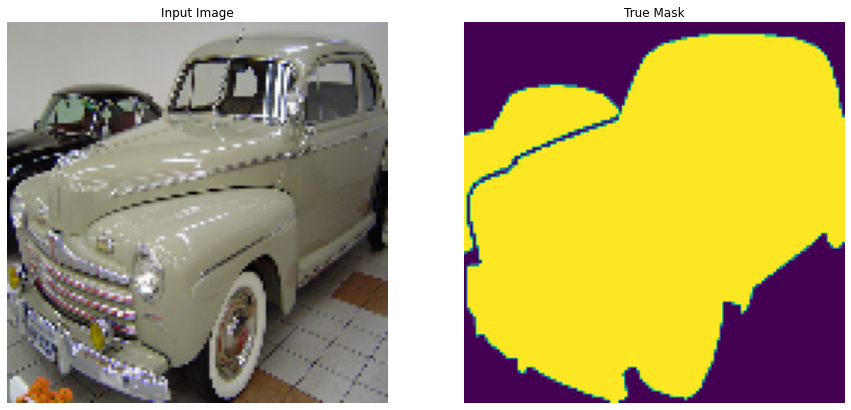

In [38]:
display([sample_image[0], sample_mask[0]])

## Model definition

In [ ]:
NUM_CLASSES = 21
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
base_model.summary()

In [63]:
def segmentation_model(NUM_CLASSES):
  base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
  down_sample = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('block_16_project').output)  # output dim: 4x4x320

  up_sample = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(512, kernel_size=3, strides=2, activation='relu', padding='same'),  #8x8x512
        tf.keras.layers.Conv2DTranspose(256, kernel_size=3, strides=2, activation='relu', padding='same'),  #16x16x256
        tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),  #32x32x128
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),   #64x64x64
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),   #128x128x64
        tf.keras.layers.Conv2D(NUM_CLASSES, kernel_size=1, padding='same')])                                #128x128x3
  
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  downsampled_input = down_sample(inputs)
  upsampled_output = up_sample(downsampled_input)
  return tf.keras.Model(inputs=inputs, outputs=upsampled_output)


## Train the model


In [64]:
model = segmentation_model(NUM_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [65]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [67]:
EPOCHS = 50
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=50)

Epoch 1/50
50/50 [==============================] - 227s 2s/step - loss: 1.8610 - accuracy: 0.6495
Epoch 2/50
50/50 [==============================] - 11s 214ms/step - loss: 1.0699 - accuracy: 0.7449
Epoch 3/50
50/50 [==============================] - 11s 213ms/step - loss: 1.0273 - accuracy: 0.7351
Epoch 4/50
50/50 [==============================] - 11s 214ms/step - loss: 0.9600 - accuracy: 0.7508
Epoch 5/50
50/50 [==============================] - 11s 215ms/step - loss: 0.9081 - accuracy: 0.7553
Epoch 6/50
50/50 [==============================] - 11s 215ms/step - loss: 0.8817 - accuracy: 0.7522
Epoch 7/50
50/50 [==============================] - 11s 215ms/step - loss: 0.8439 - accuracy: 0.7616
Epoch 8/50
50/50 [==============================] - 11s 214ms/step - loss: 0.8168 - accuracy: 0.7652
Epoch 9/50
50/50 [==============================] - 11s 213ms/step - loss: 0.8151 - accuracy: 0.7564
Epoch 10/50
50/50 [==============================] - 11s 214ms/step - loss: 0.7290 - accuracy

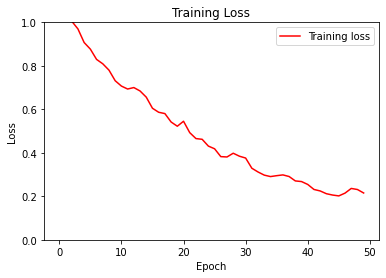

In [68]:
loss = model_history.history['loss']
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Predict on selected test images from PASCAL VOC dataset

In [181]:
def decode_labels(mask, num_classes=21):
    # colour map
    label_colours = [(0, 0, 0)
                     # 0=background
                     , (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128)
                     # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                     , (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0)
                     # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                     , (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128)
                     # 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person
                     , (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]
                     # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
    h, w = mask.shape

    img = Image.new('RGB', (w, h))
    pixels = img.load()
    for j_, j in enumerate(mask[:, :]):
        for k_, k in enumerate(j):
            if k < num_classes:
                pixels[k_, j_] = label_colours[k]
            else:
                pixels[k_, j_] = (255, 255, 255)
    output = np.array(img) #.transpose(2, 0, 1)

    return output

In [179]:
test_dir = '/content/drive/MyDrive/Assignment2_PascalVOC/VOC2012/JPEGImages/'
gtlabels_dir = '/content/drive/MyDrive/Assignment2_PascalVOC/VOC2012/SegmentationClass_1D/'
gt_maps_dir = '/content/drive/MyDrive/Assignment2_PascalVOC/VOC2012/SegmentationClass/'

In [189]:
test_images= ['2007_000464','2007_000713','2007_001288', '2007_001408', '2007_001764','2007_000042']

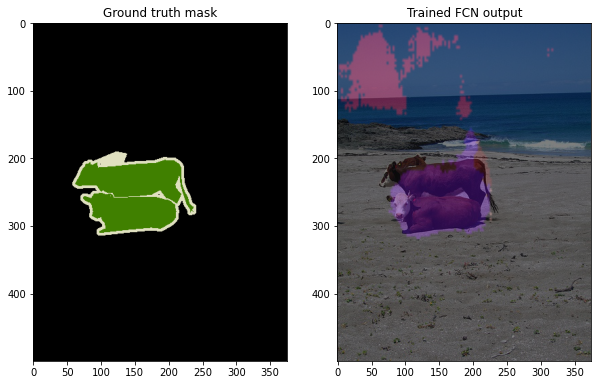

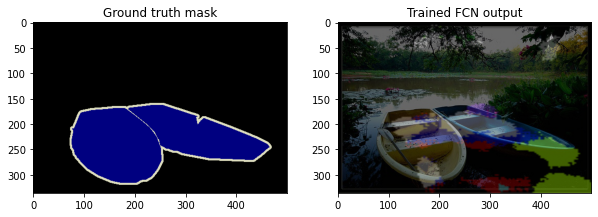

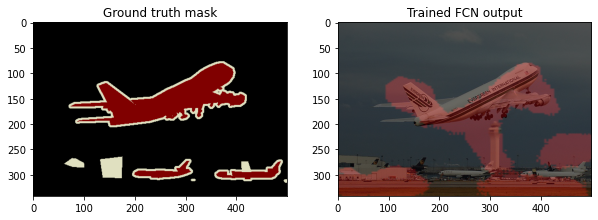

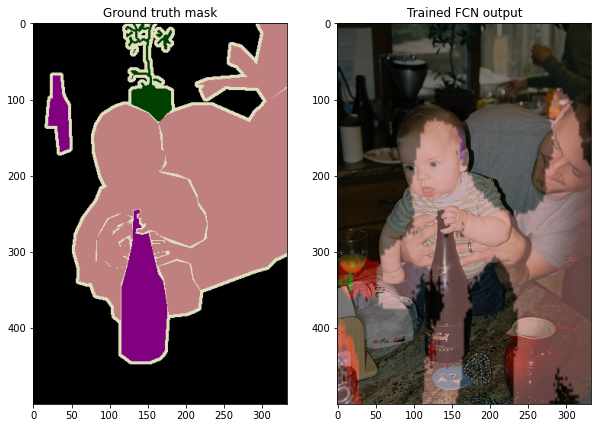

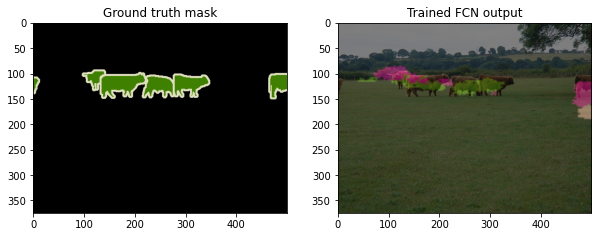

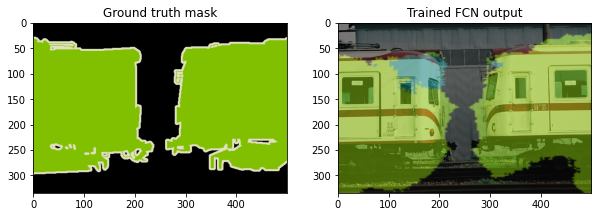

In [209]:
from skimage.io import imread
for img in test_images:
  img_path = test_dir + img + '.jpg'
  gt_path = gtlabels_dir + img + '.png'
  image = imread(img_path)
  n_pixel = image.shape[0]*image.shape[1]
  gt = imread(gt_path)
  gt[np.where(gt==255)]=0

  im = resize(image,(128,128))
  pred_mask = model.predict(im[tf.newaxis, ...])
  pred_mask = np.argmax(pred_mask,axis=-1)[0]
  pred = resize(pred_mask, (image.shape[0],image.shape[1]))

  gt_map = imread(gt_maps_dir + img + '.png')
  out = np.array(decode_labels(pred_mask))
  out = resize(out, image.shape)
  plt.figure(figsize=(10, 10))
  plt.subplot(1,2,1)
  plt.imshow(gt_map)
  plt.title('Ground truth mask')
  plt.subplot(1,2,2)
  plt.imshow(image)
  plt.imshow(out, alpha = 0.5)
  plt.title('Trained FCN output')
  plt.show()